In [12]:
import os 
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
data = {}
path = r"G:\Mi unidad\walknet_datalake\sources\osm\level2\_old"
for f in os.listdir(path):
    if f.endswith("polygon.csv"):
        try:
            d = pd.read_csv(os.path.join(path,f),sep=";")
            d = d[d['category'] == 'land use - park']
            d.geometry = d.geometry.apply(loads)
            d = gpd.GeoDataFrame(d,geometry = 'geometry',crs = 25830)
            d['area_ha'] = round((d['geometry'].area) / 100000, 0)
            #print(d.sort_values(by='area_ha'))
            #acho
            f = f.split("_")[2]
            data.update({f:d})
        except Exception as e:
            
            print(e, f)
            pass

In [13]:
data = pd.concat(data.values())
#data = data[data['area_ha']>0]
data['class'] = "S"
data.loc[data['area_ha']>=2,'class'] = "M"
data.loc[data['area_ha']>=20,'class'] = "L"
#data.to_file(r"C:\Users\katul\Downloads\test_parks_area.gpkg",driver="GPKG")

In [14]:
from shapely.geometry import Point

# Function to explode polygons into vertices
def extract_vertices(gdf):
    rows = []
    
    # Iterate over each row in the GeoDataFrame
    for idx, row in gdf.iterrows():
        geom = row.geometry
        
        # Check if it's a polygon or a multipolygon
        if geom.type == 'Polygon':
            # Extract exterior coordinates
            vertices = list(geom.exterior.coords)
        elif geom.type == 'MultiPolygon':
            vertices = []
            for poly in geom:
                vertices.extend(list(poly.exterior.coords))
        else:
            continue
        
        # Create a new row for each vertex
        for vertex in vertices:
            new_row = row.copy()  # Copy the original attributes
            new_row.geometry = Point(vertex)  # Replace geometry with vertex
            rows.append(new_row)
    
    # Create a new GeoDataFrame with the exploded vertices
    vertices_gdf = gpd.GeoDataFrame(rows, crs=gdf.crs)
    return vertices_gdf

# Example usage
# gdf is your original GeoDataFrame with polygons



In [15]:
def simplify_geometries(gdf, tolerance):
    # Apply the simplify method to each geometry
    gdf['geometry'] = gdf.geometry.simplify(tolerance, preserve_topology=True)
    return gdf

# Example usage
tolerance = 50  # Adjust the tolerance based on your specific needs
print(f"Original polygons are {len(data)}")
simplified_gdf = simplify_geometries(data, tolerance)
print(f"Simplified polygons are {len(simplified_gdf)}")

Original polygons are 4958
Simplified polygons are 4958


In [16]:
print(f"Original vertices up to {len(extract_vertices(data))}")
vertices_gdf = extract_vertices(simplified_gdf)
print(f"Simplified vertices up to {len(vertices_gdf)}")

C:\Users\katul\AppData\Local\Temp\ipykernel_8404\270780628.py:12: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Polygon':


Original vertices up to 34602
Simplified vertices up to 34602


array([[<Axes: title={'center': 'area_ha'}>]], dtype=object)

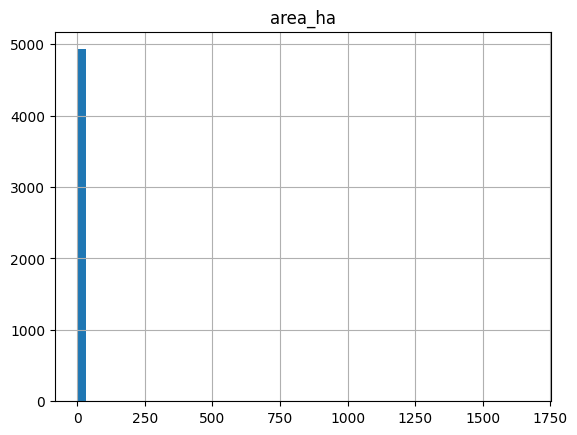

In [17]:
data.hist('area_ha',bins=50)

In [18]:
vertices_gdf['id'] = vertices_gdf['id']+"-"+vertices_gdf['class']
vertices_gdf.drop(columns=['area_ha','class'],inplace=True)
vertices_gdf

,id,id_class,category,provider,data,geometry
0,221-1184528542-0-S,aois,land use - park,2,"{'type': 'park', 'area': 5413.516251848058}",POINT (443704.055 4485725.716)
0,221-1184528542-0-S,aois,land use - park,2,"{'type': 'park', 'area': 5413.516251848058}",POINT (443674.417 4485828.4)
0,221-1184528542-0-S,aois,land use - park,2,"{'type': 'park', 'area': 5413.516251848058}",POINT (443755.343 4485674.266)
0,221-1184528542-0-S,aois,land use - park,2,"{'type': 'park', 'area': 5413.516251848058}",POINT (443832.693 4485697.551)
0,221-1184528542-0-S,aois,land use - park,2,"{'type': 'park', 'area': 5413.516251848058}",POINT (443756.666 4485669.927)
...,...,...,...,...,...,...
34,2224-585688029-34-S,aois,land use - park,2,"{'type': 'park', 'area': 4273.505419756524}",POINT (459246.134 4469891.33)
34,2224-585688029-34-S,aois,land use - park,2,"{'type': 'park', 'area': 4273.505419756524}",POINT (459203.127 4469881.573)
34,2224-585688029-34-S,aois,land use - park,2,"{'type': 'park', 'area': 4273.505419756524}",POINT (459180.452 4469973.606)
34,2224-585688029-34-S,aois,land use - park,2,"{'type': 'park', 'area': 4273.505419756524}",POINT (459222.378 4469987.586)


In [20]:
vertices_gdf = vertices_gdf.reset_index(drop=True)
vertices_gdf['idx'] = vertices_gdf.index
vertices_gdf['id'] = vertices_gdf['idx'].astype(str)+"-"+vertices_gdf['id']

In [21]:
vertices_gdf.to_csv(r"G:\Mi unidad\walknet_datalake\sources\osm\level2\level2_osm_all_point.csv",sep=";",index=False)
